In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torchvision.transforms.functional as TF
import random
import torch.nn as nn

In [44]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda
from tqdm import tqdm

from dataset import GTA

In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [46]:
scaling_factor = 2
crop_size = 96*scaling_factor
large_kernel_size = 9
small_kernel_size = 3
n_channels = 64
n_blocks = 16
lr_img_type = '[0, 1]'#'gta-small-norm'#
hr_img_type = '[0, 1]'#'[-1, 1]'

batch_size = 8
epochs = 4
lr = 1e-4
#grad_clip = None

train_path = 'data/GTAV/small/'
training_data = GTA(train_path,'train',crop_size, scaling_factor,lr_img_type,hr_img_type)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [47]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out + identity)

class AdvancedUpscaleNet(nn.Module):
    def __init__(self, upscale_factor=2, num_residuals=8):
        super(AdvancedUpscaleNet, self).__init__()
        self.entry = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(64) for _ in range(num_residuals)]
        )

        self.conv_mid = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.out_conv = nn.Conv2d(64, 3 * (upscale_factor ** 2), kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

    def forward(self, x):
        x = self.entry(x)
        x = self.res_blocks(x)
        x = self.conv_mid(x)
        x = self.pixel_shuffle(self.out_conv(x))
        return x

In [48]:
torch.cuda.empty_cache()
criterion = nn.MSELoss().to(device)
checkpoint = 'checkpoint_custom_model.pth.tar'
#checkpoint = None
if checkpoint is not None:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    model = checkpoint['model']
    optimizer = checkpoint['optimizer']
else:
    model = AdvancedUpscaleNet().to(device)
    optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()),lr=lr)
    start_epoch = 0

C:\Users\Robert\AppData\Local\Temp\ipykernel_2196\2992988900.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint)


In [49]:
losses = []

for epoch in range(epochs):
    print("EPOCH",epoch+start_epoch+1)
    running_loss = 0
    print_freq = 20
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1+start_epoch}/{epochs+start_epoch}")
    for i,(lr_imgs, hr_imgs) in enumerate(loop):
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)

        sr_imgs = model(lr_imgs)

        loss = criterion(sr_imgs, hr_imgs)

        optimizer.zero_grad()
        loss.backward()

        # # Clip gradients, if necessary
        # if grad_clip is not None:
        #     clip_gradient(optimizer, grad_clip)

        optimizer.step()
        running_loss += loss.item()
        if i % print_freq==print_freq-1:
            current_loss = running_loss / print_freq
            losses.append(current_loss)
            running_loss = 0

            loop.set_postfix(loss=current_loss)

    torch.save({'epoch': epoch+start_epoch,
                    'model': model,
                    'optimizer': optimizer},
                   'checkpoint_custom_model.pth.tar')

EPOCH 5


Epoch 5/8: 100%|██████████| 313/313 [00:29<00:00, 10.55it/s, loss=0.00321]


EPOCH 6


Epoch 6/8: 100%|██████████| 313/313 [00:29<00:00, 10.70it/s, loss=0.00296]


EPOCH 7


Epoch 7/8: 100%|██████████| 313/313 [00:28<00:00, 11.00it/s, loss=0.00217]


EPOCH 8


Epoch 8/8: 100%|██████████| 313/313 [00:28<00:00, 10.84it/s, loss=0.00251]


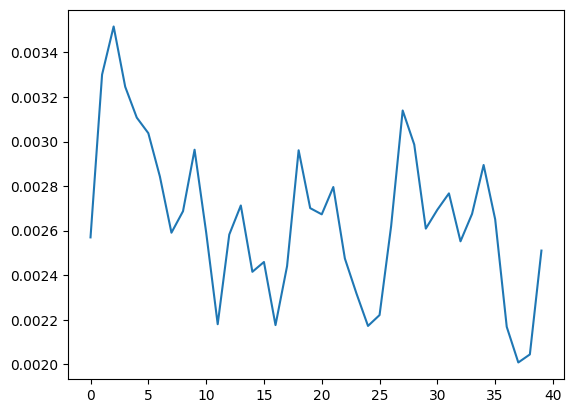

In [50]:
plt.plot(losses[20:])
plt.show()

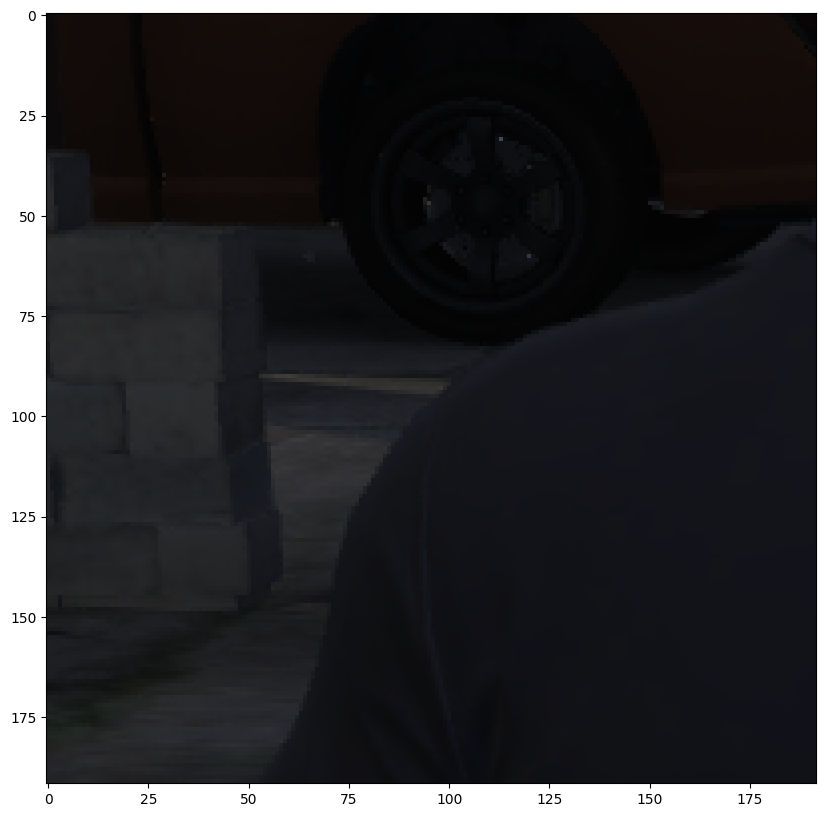

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


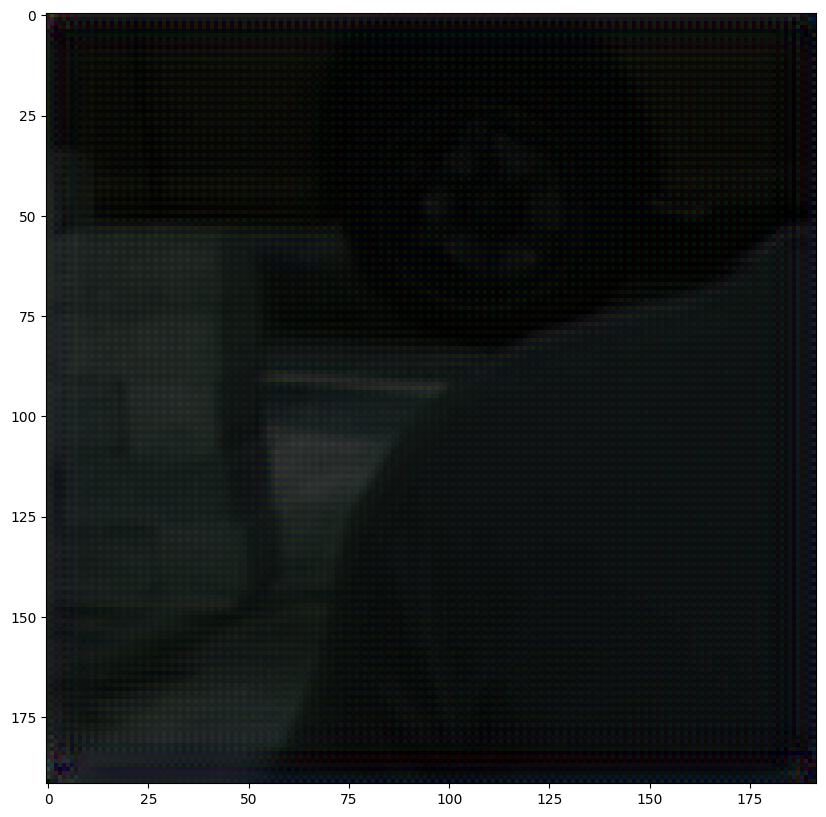

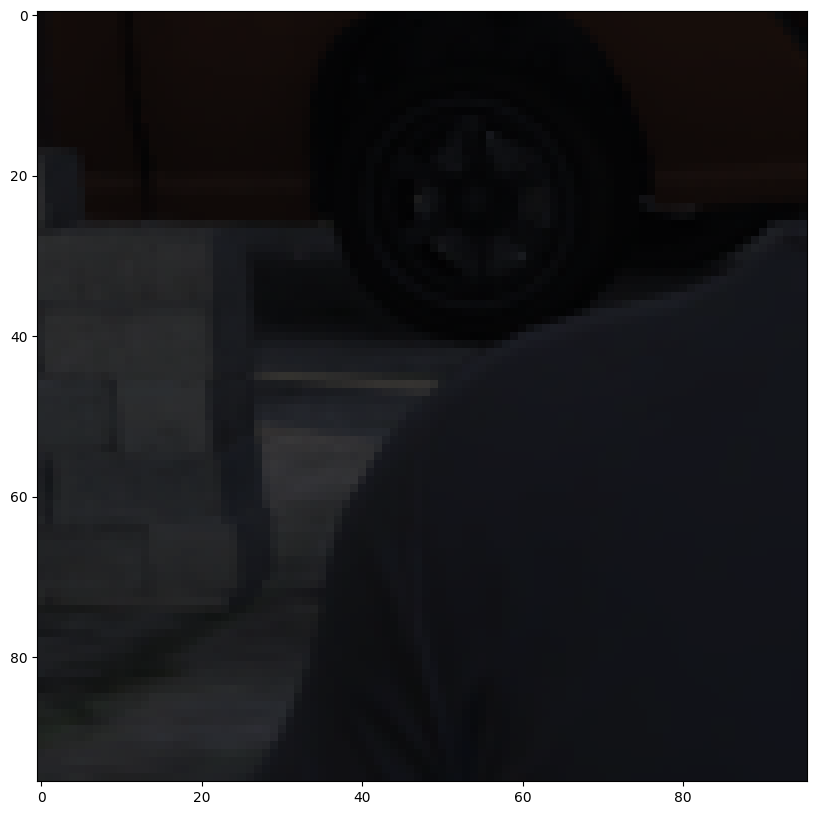

In [51]:
with torch.no_grad():
    for lr_img, hr_img in training_data:
        model.eval()
        sr_img = model(lr_img.unsqueeze(0).to(device)).to('cpu').squeeze(0).permute(1, 2, 0).numpy()
        # plt.imshow(np.concatenate([sr_img, (hr_img).permute(1, 2, 0).numpy()], axis=1))
        # plt.show()
        size = (10,10)
        plt.figure(figsize=size)
        plt.imshow((hr_img).permute(1, 2, 0).numpy())
        plt.show()
        plt.figure(figsize=size)
        plt.imshow(sr_img)
        plt.show()
        plt.figure(figsize=size)
        plt.imshow((lr_img).permute(1, 2, 0).numpy())
        plt.show()
        break

In [52]:
import torchvision.transforms.functional as FT
with torch.no_grad():
    x_hr = training_data.get_full_image(1)
    x_lr = x_hr.resize((int(x_hr.width / 2), int(x_hr.height / 2)),
                               Image.BICUBIC)
    x_lr = FT.to_tensor(x_lr).unsqueeze(0).to(device)
    x_sr = model(x_lr).to('cpu').squeeze(0).permute(1, 2, 0).numpy()
    x_sr = (((x_sr - np.min(x_sr)) / (np.max(x_sr) - np.min(x_sr)))*255).astype(np.uint8)
    plt.imsave('out.png',x_sr)